## Flattening profiles
Inspect the variation in flattening with dSph properties and orbital properties

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from run_2comp_cluster_vmaxuniversal import generate_simproperties
def load_profiles(s=2.,pmmag=0.25,ca=1.,ttype='st'):
    fldr = '/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/'
    fl='2comp_cuspplum_nfw_SP_%i_PM_%i_ca_%02d'%(int(s),int(pmmag*100.),int(ca*10.))
    print fldr,fl
    import glob
    fls = glob.glob(fldr+fl+'_flattening_profile_%s*'%ttype)
    times_list = [float(s.split('_')[-1][:-4]) for s in fls]
    fls = np.array(fls)[np.argsort(np.array(times_list))]
    times = np.sort(times_list)
    return times, fls
def load_summary(s=2.,pmmag=0.25,ca=1.):
    fldr = '/data/gaia-eso/jls/m2m/CraterII/vmax_universal/'
    fl='2comp_cuspplum_nfw_SP_%i_PM_%i_ca_%02d_properties.csv'%(int(s),int(pmmag*100.),int(ca*10.))
    return pd.read_csv(fldr+fl)
def rtidal(s=2.,pmmag=0.25,ca=1.):
    simprops = generate_simproperties(SegregationParameter=s, propermotionmag=pmmag, flattening=ca,
                                 Nparticles=4e5,output_file=False)
    return simprops['rtidal']
def rs(s=2.,pmmag=0.25,ca=1.):
    simprops = generate_simproperties(SegregationParameter=s, propermotionmag=pmmag, flattening=ca,
                                 Nparticles=4e5,output_file=False)
    return simprops['Rscale']

In [46]:
def plot_profiles(s,pmmag,ca,ba_cut=1.):
    
    times,fls = load_profiles(s=s,pmmag=pmmag,ca=ca,ttype='st')
    CS = plt.imshow(np.random.random((10,10))*times[-1],vmin=0.,vmax=times[-1],cmap=plt.cm.viridis)
    plt.clf()
    Rs = rs()
    f,a=plt.subplots(1,3,figsize=[7.,3.])
    for T, F in zip(times, fls):
        dd = pd.read_csv(F)
        a[0].plot(dd['radii_st']/Rs,dd['ba_st'],c=plt.cm.viridis(T/times[-1]),alpha=0.4,lw=3)
        a[1].plot(dd['radii_st']/Rs,dd['ca_st'],c=plt.cm.viridis(T/times[-1]),alpha=0.4,lw=3)
        fltr = (dd['ba_st']<ba_cut)
        a[2].plot((dd['radii_st']/Rs)[fltr][:-1],dd['align_st'][fltr][:-1],c=plt.cm.viridis(T/times[-1]),alpha=0.4,lw=3)
    lbl=[r'$b/a$',r'$c/a$',r'$\cos\,\eta$']
    for i in range(3):
        plt.sca(a[i])
        plt.semilogx()
        plt.xlim(0.1,10.)
        plt.ylim(0.,1.)
        plt.xlabel(r'$r/r_{s\mathrm{DM}}$')
        plt.annotate(lbl[i],xy=(0.1,0.1),xycoords='axes fraction',fontsize=16)
        if i>0:
            plt.gca().set_yticklabels([])
            plt.gca().xaxis.get_major_ticks()[1].set_visible(False)
    plt.subplots_adjust(wspace=0., right=0.9)
    cbar_ax = f.add_axes([0.84, 0., 0.1, 1.])
    cbar_ax.axis('off')
    f.colorbar(CS, ax=cbar_ax,label=r'Time / $\mathrm{Gyr}$')
#     plt.tight_layout()

def plot_shapes_mass():
    slist=[1.,2.]
    pmmaglist=[0.05,0.1,0.17,0.25]
    f,a=plt.subplots(1,3,figsize=[7.,3.])
    for s in slist:
        for cc,pmmag in enumerate(pmmaglist):
            for ca in [0.3,1.]:
                times,fls = load_profiles(s=s,pmmag=pmmag,ca=ca,ttype='st')
                data = load_summary(s=s,pmmag=pmmag,ca=ca)
                mrange=np.zeros(len(fls))
                cashape = np.zeros(len(fls))
                bashape = np.zeros(len(fls))
                epsrange = np.zeros(len(fls))
                srange = np.zeros(len(fls))
                for II, F in enumerate(fls):
                    dd = pd.read_csv(F)
                    mrange[II] = data['mass_dm_core_init'][II]/data['mass_dm_core_init'][0]
                    epsrange[II] = data['eps'][II]
                    bashape[II] = np.mean(dd['ba_st'][dd['radii_st']<.5*data['r_half'][0]])
                    cashape[II] = np.mean(dd['ca_st'][dd['radii_st']<.5*data['r_half'][0]])
                    srange[II] = data['s'][II]
                mkr = '.'
                ms=15
                lbl=r'$%0.2f$'%pmmag
                if ca==0.3 or s==2.:
                    mkr = '^'
                    ms=7
                    lbl=None
                fltr = srange>20.
                a[0].plot(mrange[fltr],bashape[fltr],mkr,ms=ms,
                          color=sns.color_palette()[cc],zorder=4-cc, alpha=0.8)
                a[1].plot(mrange[fltr],cashape[fltr],mkr,ms=ms,
                          color=sns.color_palette()[cc],label=lbl,zorder=4-cc, alpha=0.8)
                a[2].plot(mrange[fltr],1.-epsrange[fltr],mkr,ms=ms,
                          color=sns.color_palette()[cc],zorder=4-cc, alpha=0.8)

    plt.subplots_adjust(wspace=0., right=0.9)
    lbl=[r'$b/a$',r'$c/a$',r'$1-\epsilon$']
    for i in range(3):
        plt.sca(a[i])
        plt.semilogx()
        plt.xlim(1e-2,1.)
        plt.ylim(0.2,1.)
        plt.xlabel(r'$M_\mathrm{h}/M_\mathrm{h0}$')
        plt.annotate(lbl[i],xy=(0.1,0.1),xycoords='axes fraction',fontsize=16)
        if i>0:
            plt.gca().set_yticklabels([])
            plt.gca().xaxis.get_major_ticks()[1].set_visible(False)
    plt.axhline(0.9,color='k',alpha=0.7,zorder=6)
    plt.sca(a[1])
    plt.legend(ncol=4,loc='lower center',bbox_to_anchor=(0.5,1.0))
    
def plot_density_profiles(s,pmmag,ca):
    dd0,ddm0=0.,0.
    times,fls = load_profiles(s=s,pmmag=pmmag,ca=ca,ttype='st')
    times,fls_dm = load_profiles(s=s,pmmag=pmmag,ca=ca,ttype='dm')
    CS = plt.imshow(np.random.random((10,10))*times[-1],vmin=0.,vmax=times[-1],cmap=plt.cm.viridis)
    plt.clf()
    Rs = rs()
    f,a=plt.subplots(1,2,figsize=[7.,3.])
    for T, F, FDM in zip(times, fls, fls_dm):
        dd = pd.read_csv(F)
        if dd0==0.:
            dd0=dd['dens_st'][0]
        ddm = pd.read_csv(FDM)
        if ddm0==0.:
            ddm0=ddm['dens_dm'][0]
        a[0].plot(dd['radii_st']/Rs,dd['dens_st']/dd0,c=plt.cm.viridis(T/times[-1]),alpha=0.4,lw=3)
#         a[0].plot(dd['radii_st']/Rs,dd['dens_st'][0]/(1.+(dd['radii_st']/Rs*s)**2)**2,
#                   c='k',alpha=0.4,lw=3)
        a[1].plot(ddm['radii_dm']/Rs,ddm['dens_dm']/ddm0,c=plt.cm.viridis(T/times[-1]),alpha=0.4,lw=3)
#         a[2].plot(dd['radii_st']/Rs,dd['align_st'],c=plt.cm.viridis(T/times[-1]),alpha=0.2,lw=3)
    lbl=[r'$\rho_\star$',r'$\rho_\mathrm{DM}$']
    for i in range(2):
        plt.sca(a[i])
        plt.semilogx()
        plt.semilogy()
        plt.xlim(0.1,10.)
        plt.ylim(1e-6,1.)
        plt.xlabel(r'$r/r_{s\mathrm{DM}}$')
        plt.annotate(lbl[i],xy=(0.1,0.1),xycoords='axes fraction',fontsize=16)
        if i>0:
            plt.gca().set_yticklabels([])
            plt.gca().xaxis.get_major_ticks()[1].set_visible(False)

    plt.subplots_adjust(wspace=0., right=0.9)
    cbar_ax = f.add_axes([0.84, 0., 0.1, 1.])
    cbar_ax.axis('off')
    f.colorbar(CS, ax=cbar_ax,label=r'Time / $\mathrm{Gyr}$')
#     plt.tight_layout()

/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_1_PM_5_ca_03
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_1_PM_5_ca_10
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_1_PM_10_ca_03
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_1_PM_10_ca_10
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_1_PM_17_ca_03
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_1_PM_17_ca_10
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_1_PM_25_ca_03
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_1_PM_25_ca_10
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_5_ca_03
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/

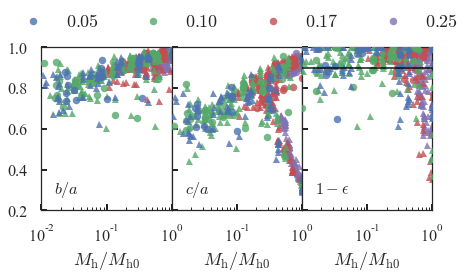

In [47]:
plot_shapes_mass()
plt.savefig('shape_with_mass.pdf',bbox_inches='tight')
# alpha=1.
# beta=0.2
# xx = np.logspace(-2.,0.)
# plt.plot(xx,2.**alpha*xx**beta/(1.+xx)**alpha)

/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_17_ca_10
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_17_ca_10
Scale radius = 0.725
Softening = 0.05157150081844565
[ 65.19547321 119.69600718  51.66028503 -82.62837589   9.90109634
  67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.17218607998280508
Mass fraction inside r_s =  0.0749852300389162
400000.0
Velocity dispersion =  12.65981047816871
0.173821208772


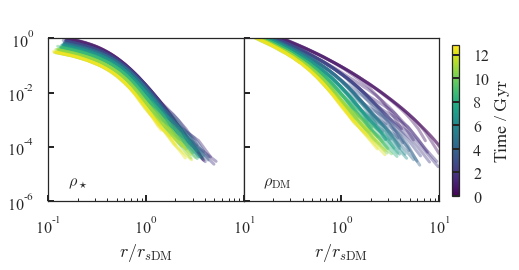

In [43]:
plot_density_profiles(2.,0.17,1.)

/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_10_ca_10
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_10_ca_10
Scale radius = 0.725
Softening = 0.0515715008184
[  65.19547321  119.69600718   51.66028503  -82.62837589    9.90109634
   67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.172186079983
Mass fraction inside r_s =  0.0749852300389
400000.0
Velocity dispersion =  12.6598104782
0.173821208772


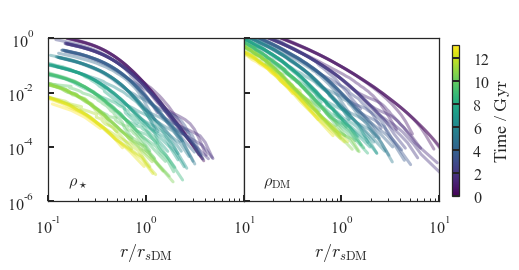

In [147]:
plot_density_profiles(2.,0.1,1.)

/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_5_ca_10
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_5_ca_10
Scale radius = 0.725
Softening = 0.0515715008184
[  65.19547321  119.69600718   51.66028503  -82.62837589    9.90109634
   67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.172186079983
Mass fraction inside r_s =  0.0749852300389
400000.0
Velocity dispersion =  12.6598104782
0.173821208772


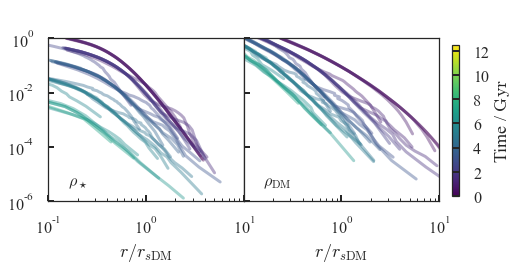

In [219]:
plot_density_profiles(2.,0.05,1.)

/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_17_ca_03
Scale radius = 0.725
Softening = 0.05157150081844565
[ 65.19547321 119.69600718  51.66028503 -82.62837589   9.90109634
  67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.17218607998280502
Mass fraction inside r_s =  0.07498523003891616
400000.0
Velocity dispersion =  12.65981047816871
0.173821208772


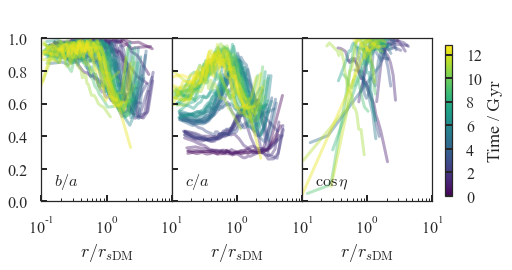

In [40]:
plot_profiles(2.,0.17,.3,ba_cut=.85)
# plot_profiles(2.,0.25,.3,coseta_cut=0.85)

/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_17_ca_10
Scale radius = 0.725
Softening = 0.0515715008184
[  65.19547321  119.69600718   51.66028503  -82.62837589    9.90109634
   67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.172186079983
Mass fraction inside r_s =  0.0749852300389
400000.0
Velocity dispersion =  12.6598104782
0.173821208772
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_17_ca_03
Scale radius = 0.725
Softening = 0.0515715008184
[  65.19547321  119.69600718   51.66028503  -82.62837589    9.90109634
   67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.172186079983
Mass fraction inside r_s =  0.0749852300389
400000.0
Velocity dispersion =  12.6598104782
0.173821208772


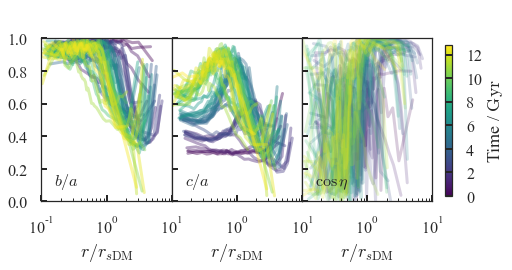

In [215]:
plot_profiles(2.,0.17,1.)
plt.savefig('flattening_profiles_pm17_ca10.pdf',bbox_inches='tight')
plot_profiles(2.,0.17,.3)
plt.savefig('flattening_profiles_pm17_ca03.pdf',bbox_inches='tight')

/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_17_ca_10
Scale radius = 0.725
Softening = 0.05157150081844565
[ 65.19547321 119.69600718  51.66028503 -82.62837589   9.90109634
  67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.17218607998280502
Mass fraction inside r_s =  0.07498523003891618
400000.0
Velocity dispersion =  12.65981047816871
0.173821208772
/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_17_ca_03
Scale radius = 0.725
Softening = 0.05157150081844565
[ 65.19547321 119.69600718  51.66028503 -82.62837589   9.90109634
  67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.17218607998280466
Mass fraction inside r_s =  0.07498523003891583
400000.0
Velocity dispersion =  12.65981047816871
0.173821208772


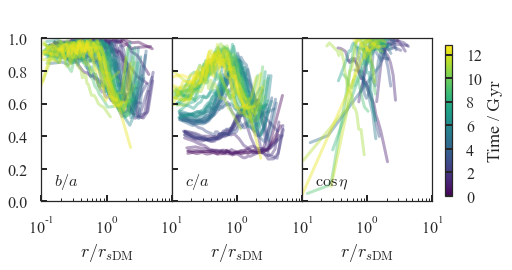

In [41]:
plot_profiles(2.,0.17,1.,ba_cut=0.85)
plt.savefig('flattening_profiles_pm17_ca10_bacut.pdf',bbox_inches='tight')
plot_profiles(2.,0.17,.3,ba_cut=0.85)
plt.savefig('flattening_profiles_pm17_ca03_bacut.pdf',bbox_inches='tight')

/data/gaia-eso/jls/m2m/CraterII/vmax_universal/flattening_profiles/ 2comp_cuspplum_nfw_SP_2_PM_10_ca_10
Scale radius = 0.725
Softening = 0.0515715008184
[  65.19547321  119.69600718   51.66028503  -82.62837589    9.90109634
   67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.172186079983
Mass fraction inside r_s =  0.0749852300389
400000.0
Velocity dispersion =  12.6598104782
0.173821208772


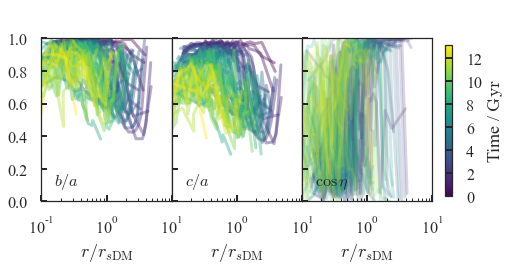

In [5]:
plot_profiles(2.,0.1,1.)
# plot_profiles(2.,0.1,.3)

Scale radius = 0.725
Softening = 0.0515715008184
[  65.19547321  119.69600718   51.66028503  -82.62837589    9.90109634
   67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.176099900266
Mass fraction inside r_s =  0.0749852300389
400000.0
Velocity dispersion =  12.6598104782
Scale radius = 0.725
Softening = 0.0515715008184
[  65.19547321  119.69600718   51.66028503  -82.62837589    9.90109634
   67.2656748 ]
Tidal radius =  10.3447574722
Time unit:  0.176099900266
Mass fraction inside r_s =  0.0749852300389
400000.0
Velocity dispersion =  12.6598104782


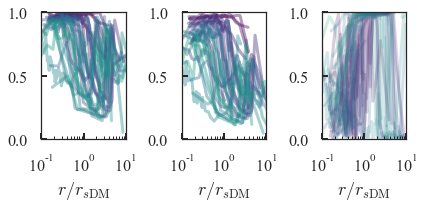

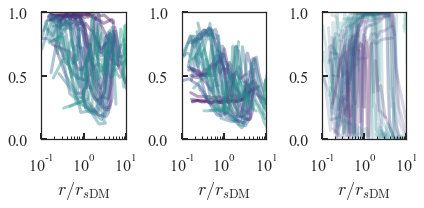

In [37]:
plot_profiles(2.,0.05,1.)
plot_profiles(2.,0.05,.3)